In [253]:
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cross_validation import train_test_split
from pretrainedmodels.models import bninception

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time

import matplotlib.pyplot as plt
from PIL import Image

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import copy
from scipy import stats
import scipy.signal as signal
from imgaug import augmenters as iaa

random_seed = 4050
config_batch_size = 16
class_n = (9 + 10 + 26)
output_n = 9
num_epochs = 100
mu ,sigma = 0, 5
feature_extract = True
use_pretrained=True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

char_to_index = {"深":0, "秦":1, "京":2, "海":3, "成":4, "南":5, "杭":6, "苏":7, "松":8}
print(char_to_index)

{'深': 0, '秦': 1, '京': 2, '海': 3, '成': 4, '南': 5, '杭': 6, '苏': 7, '松': 8}


In [254]:
label_file = "./data/train-data-label.txt"
image_file = "./data/train-data"
data_list = []
with open(label_file, 'r') as file_to_read:
    while True:
        lines = file_to_read.readline().strip() # 整行读取数据
        if not lines:
            break
        lines = lines.split(",  ")
        image_path = os.path.join(image_file, lines[1])
        label = [];
        label.append(char_to_index[lines[0][0]])
        for i in range(1, len(lines[0])):
            if '0' <= lines[0][i] and lines[0][i] <= '9':
                label.append(9 + ord(lines[0][i]) - ord('0'))
            else:
                label.append(9 + 10 + ord(lines[0][i]) - ord('A'))
        data_list.append({"image_path": image_path, "label":label})

In [387]:
def numpy_shear(img, val):
    img = np.expand_dims(img, axis = 0)
    img = np.expand_dims(img, axis = 3)
    print(img.shape)

    seq = iaa.Sequential([
        iaa.Affine(shear=(val, val)),
    ])

    img = seq.augment_images(img)
    img = np.squeeze(img)
    return img

def numpy_rotate(img, val):
    img = np.expand_dims(img, axis = 0)
    img = np.expand_dims(img, axis = 3)
    print(img.shape)

    seq = iaa.Sequential([
        iaa.CropAndPad(
            px=((10, 10), (10, 10), (10, 10), (10, 10)),
            pad_cval=(0, 128)
        ),
        #iaa.Affine(rotate=val),
    ])

    img = seq.augment_images(img)
    img = np.squeeze(img)
    return img

def horizontal_difference(img):
    h,w = img.shape
    for i in range(h - 1):
        for j in range(w - 1):
            img[i, j] = abs(img[i, j] - img[i, j + 1]) 
    return img

def vertical_difference(img):
    h,w = img.shape
    for i in range(h - 1):
        for j in range(w - 1):
            img[i, j] = abs(img[i, j] - img[i + 1, j]) 
    return img

def hog_difference(img):
    h,w = img.shape
    for i in range(h - 1):
        for j in range(w - 1):
            img[i, j] = abs(img[i, j] - img[i + 1, j + 1]) 
    return img

{'image_path': './data/train-data/3502f7b685cee102.jpg', 'label': [2, 36, 32, 17, 40, 38, 35, 36, 17]}
min_pixel =  0
max_pixel =  255
(70, 356)


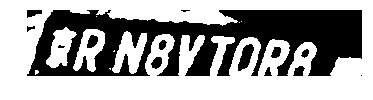

In [394]:
data_index = 3003
print(data_list[data_index])
img = Image.open(data_list[data_index]["image_path"])
img = img.convert('L')
img = np.array(img)
img = signal.medfilt2d(img, kernel_size=3)
h,w = img.shape

pixel_threshold = 0
for i in range(h):
    for j in range(w):
        pixel_threshold += img[i, j]
pixel_threshold /= (w * h)

for i in range(h):
    for j in range(w):
        if img[i, j] > pixel_threshold:
            img[i, j] = 255
        else:
            img[i, j] = 0

small_count, big_count = 0, 0
for i in range(h):
    for j in range(w):
        if img[i, j] < pixel_threshold:
            small_count += 1
        else:
            big_count += 1
if small_count < big_count:
    for i in range(h):
        for j in range(w):
            img[i, j] = 255 - img[i, j]
# the normalize
min_pixel, max_pixel = 1e6, 0
for i in range(h):
    for j in range(w):
        min_pixel = min(min_pixel, img[i, j])
        max_pixel = max(max_pixel, img[i, j])
print("min_pixel = ", min_pixel)
print("max_pixel = ", max_pixel)
for i in range(h):
    for j in range(w):
        img[i, j] = (img[i, j] - min_pixel) * 255 / (max_pixel - min_pixel)

#img = numpy_rotate(img, -4)
#img = numpy_shear(img, -20)
#img = hog_difference(img)
#img = vertical_difference(img)
#img = horizontal_difference(img)

print(img.shape)
h,w = img.shape

plt.figure("love")
plt.imshow(img, cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

avg_big_count =  80.28571428571429
y_big_count =  [1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 16, 15, 18, 57, 100, 129, 139, 158, 150, 143, 132, 125, 125, 136, 146, 153, 151, 161, 167, 165, 167, 172, 166, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0]
res =  64 l =  5 r =  68


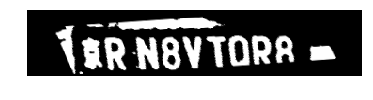

In [375]:
y_big_count = [0] * h
avg_big_count = 0
for i in range(h):
    for j in range(w):
        if img[i, j] >= pixel_threshold:
            y_big_count[i] += 1
            avg_big_count += 1
avg_big_count /= h
"""
for i in range(h):
    if y_big_count[i] > avg_big_count:
        y_big_count[i] = 1
    else:
        y_big_count[i] = 0
res, res_l, res_r = 0,0,0
l=-1
for r in range(h):
    if y_big_count[r] == 1:
        if r - l > res:
            res = r - l
            res_l = l
            res_r = r
    else:
        l = r
"""
min_index_list = []
for i in range(2):
    min_val = 1e6
    min_index = -1
    for j in range(5, h):
        if min_val > y_big_count[j]:
            min_val = y_big_count[j]
            min_index = j
    for j in range(max(0, min_index - 20), min(h, min_index + 20)):
        y_big_count[j] = 1e6
    min_index_list.append(min_index)
res_l = min(min_index_list[0], min_index_list[1])
res_r = max(min_index_list[0], min_index_list[1])
res = res_r - res_l + 1;
print("avg_big_count = ", avg_big_count)
print("y_big_count = ", y_big_count)
print("res = ", res, "l = ", res_l, "r = ", res_r)

res_l = max(0, res_l - 5)
res_r = min(h, res_r + 5)

img = img[res_l:res_r]
plt.figure("love")
plt.imshow(img, cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

avg_big_count =  15.786516853932584
x_big_count =  [1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 17, 19, 23, 26, 32, 34, 36, 39, 41, 44, 40, 25, 19, 13, 0, 0, 0, 0, 0, 2, 3, 4, 6, 7, 19, 23, 28, 30, 34, 34, 33, 34, 33, 31, 32, 32, 30, 28, 27, 23, 10, 8, 6, 1, 0, 3, 11, 19, 26, 34, 38, 39, 35, 29, 24, 16, 15, 16, 17, 24, 34, 37, 37, 36, 31, 27, 21, 11, 8, 7, 7, 7, 8, 7, 8, 8, 10, 11, 9, 16, 25, 33, 40, 41, 39, 39, 39, 36, 27, 19, 19, 20, 21, 27, 36, 39, 40, 40, 40, 38, 32, 26, 16, 9, 9, 9, 15, 28, 37, 38, 40, 42, 38, 31, 27, 27, 27, 28, 33, 35, 40, 38, 37, 33, 22, 15, 10, 10, 10, 15, 19, 22, 25, 27, 30, 33, 32, 31, 32, 31, 32, 41, 

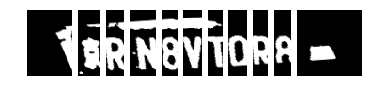

In [377]:
h, w = img.shape
width_threshold = 20
x_big_count = [0] * w
avg_big_count = 0
for i in range(h):
    for j in range(w):
        if img[i, j] >= pixel_threshold:
            x_big_count[j] += 1
            avg_big_count += 1
avg_big_count /= w

x_normal_val = x_big_count#[0] * w
"""
for i in range(w):
    for j in range(-w, w):
        if 0 <= i + j and i + j < w:
            x_normal_val[i] += x_big_count[i + j] * stats.norm.pdf(j, mu, sigma)
        else:
            x_normal_val[i] += h * stats.norm.pdf(j, mu, sigma)
"""
j = w - 1
while (j >= 0 and x_big_count[j] < avg_big_count):
    x_normal_val[j] = 1e6
    j -= 1
j = 0
while (j < w and x_big_count[j] < avg_big_count):
    x_normal_val[j] = 1e6
    j += 1

print("avg_big_count = ", avg_big_count)
print("x_big_count = ", x_big_count)
print("x_normal_val = ", x_normal_val)
print(data_list[0])
print(type(img))

for i in range(10):
    min_val = 1e6
    min_index = -1
    for j in range(w):
        if x_normal_val[j] < min_val:
            min_val = x_normal_val[j]
            min_index = j
    print("min_index = ", i, " = ", min_index, "min_val = ", min_val)
    avg_big_count = min_val + 5
    j = min_index
    while (j >= 0 and x_big_count[j] < avg_big_count):
        x_normal_val[j] = 1e6
        j -= 1
    j = min_index + 1
    while (j < w and x_big_count[j] < avg_big_count):
        x_normal_val[j] = 1e6
        j += 1
    for j in range(max(0, min_index - width_threshold), min(w, min_index + width_threshold)):
        x_normal_val[j] = 1e6
    for j in range(max(0, min_index - 3), min(w, min_index + 3)):
        for k in range(h):
            img[k, j] = 255

plt.figure("love")
plt.imshow(img, cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()